In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


df = pd.read_csv("data_tornado_merged.csv")


high_df = df[df['tor_f_scale'].isin(['F3', 'F4', 'F5'])]


geometry = [Point(xy) for xy in zip(high_df['begin_lon'], high_df['begin_lat'])]
gdf = gpd.GeoDataFrame(high_df, geometry=geometry, crs="EPSG:4326")


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")

excluded_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]

us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]




import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde


bins = ['1946-1952', '1953-1959', '1960-1966', '1967-1973', '1974-1980',
        '1981-1987', '1988-1994', '1995-2001', '2002-2008', '2009-2015',
        '2016-2022']


xmin, xmax = -125, -66
ymin, ymax = 24, 50

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])


density_stats = []

for bin_label in bins:
    bin_data = gdf[
        (gdf['year_bin'] == bin_label) &
        (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
    ]

    x = bin_data['begin_lon'].values
    y = bin_data['begin_lat'].values

    if len(x) > 0:
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy, bw_method=0.2)
        density = kde(positions).reshape(xx.shape)

        max_idx = np.argmax(density)
        peak_lon = xx.ravel()[max_idx]
        peak_lat = yy.ravel()[max_idx]
        peak_density = density.ravel()[max_idx]

        density_stats.append({
            'year_bin': bin_label,
            'peak_lat': peak_lat,
            'peak_lon': peak_lon,
            'peak_density': peak_density,
            'mean_lat': np.mean(y),
            'mean_lon': np.mean(x),
            'std_lat': np.std(y),
            'std_lon': np.std(x),
            'num_points': len(x)
        })
    else:
        # Add a placeholder for empty bins
        density_stats.append({
            'year_bin': bin_label,
            'peak_lat': np.nan,
            'peak_lon': np.nan,
            'peak_density': 0,
            'mean_lat': np.nan,
            'mean_lon': np.nan,
            'std_lat': np.nan,
            'std_lon': np.nan,
            'num_points': 0
        })

# Convert to DataFrame
df_stats = pd.DataFrame(density_stats)
#df_stats.to_csv("6_tornado_density_peaks_by_bin.csv", index=False)
print("Saved: tornado_density_peaks_by_bin.csv")






Saved: tornado_density_peaks_by_bin.csv


In [3]:
df_stats.sort_values(by='peak_density', ascending=False).head()


,year_bin,peak_lat,peak_lon,peak_density,mean_lat,mean_lon,std_lat,std_lon,num_points
0,1946-1952,35.555556,-89.838384,0.020519,37.659802,-91.720495,4.354908,5.932442,101
9,2009-2015,33.979798,-87.454545,0.018516,36.744992,-90.683217,3.802104,6.426599,364
8,2002-2008,36.868687,-87.454545,0.012719,37.545584,-91.265284,3.891793,5.587517,312
6,1988-1994,38.707071,-86.858586,0.012683,37.695525,-91.403845,3.829053,7.023809,396
2,1960-1966,40.808081,-85.666667,0.011643,37.926478,-92.111221,4.153429,6.083321,565


### A Gaussian white noise model.

One baseline model is the <i>Gaussian white noise model</i>.  

We hypothesize a data generating process of the form:

$$
f(t) = \mu + \epsilon_t
$$

with $\mu$ as some constant and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$.  In this context we can call our error terms "Gaussian white noise".

The MLE fitted model will have $\hat{\mu} = \displaystyle \frac{1}{n}\sum_{i=1}^n y_i$, and $\hat{\sigma}^2 = \displaystyle \frac{1}{n} \sum_{i=1}^n (y - \hat{\mu})^2$.

### Average Forecast

This leads to the **average forecast**:  To predict the value of $y_t$ for $t>n$ we just report $\hat{\mu} = \displaystyle \frac{1}{n}\sum_{i=1}^n y_i$.

<i>Note: for this estimate to be "good" the assumption that the $y_t$ are independent and identically distributed</i>.

In [4]:

def midpoint(bin_label):
    start, end = map(int, bin_label.split('-'))
    return (start + end) // 2

df_stats['year'] = df_stats['year_bin'].apply(midpoint)


ts = df_stats[['year', 'peak_density']].dropna().sort_values('year')


In [5]:

mu_hat = ts['peak_density'].mean()
sigma_hat_sq = ts['peak_density'].var()

print(f"Mean (mû): {mu_hat:.6f}")
print(f"Variance (sigmâ²): {sigma_hat_sq:.6e}")


Mean (mû): 0.011878
Variance (sigmâ²): 1.810907e-05


In [6]:
forecast_2030 = mu_hat
print(f"Forecast for 2030 peak tornado density: {forecast_2030:.6f}")


Forecast for 2030 peak tornado density: 0.011878


In [8]:
df_stats = pd.read_csv("6_tornado_density_peaks_by_bin.csv")

# Drop NaNs and sort
df_stats = df_stats.dropna(subset=['peak_lat', 'peak_lon'])
df_stats = df_stats.sort_values(by='year_bin')

# Get midpoint year
df_stats['year'] = df_stats['year_bin'].apply(lambda b: (int(b.split('-')[0]) + int(b.split('-')[1])) // 2)


In [9]:
lat_mu = df_stats['peak_lat'].mean()
lon_mu = df_stats['peak_lon'].mean()

lat_sigma = df_stats['peak_lat'].std()
lon_sigma = df_stats['peak_lon'].std()

print(f"Forecast 2030 location: ({lat_mu:.2f}°N, {lon_mu:.2f}°W)")


Forecast 2030 location: (35.79°N, -88.97°W)


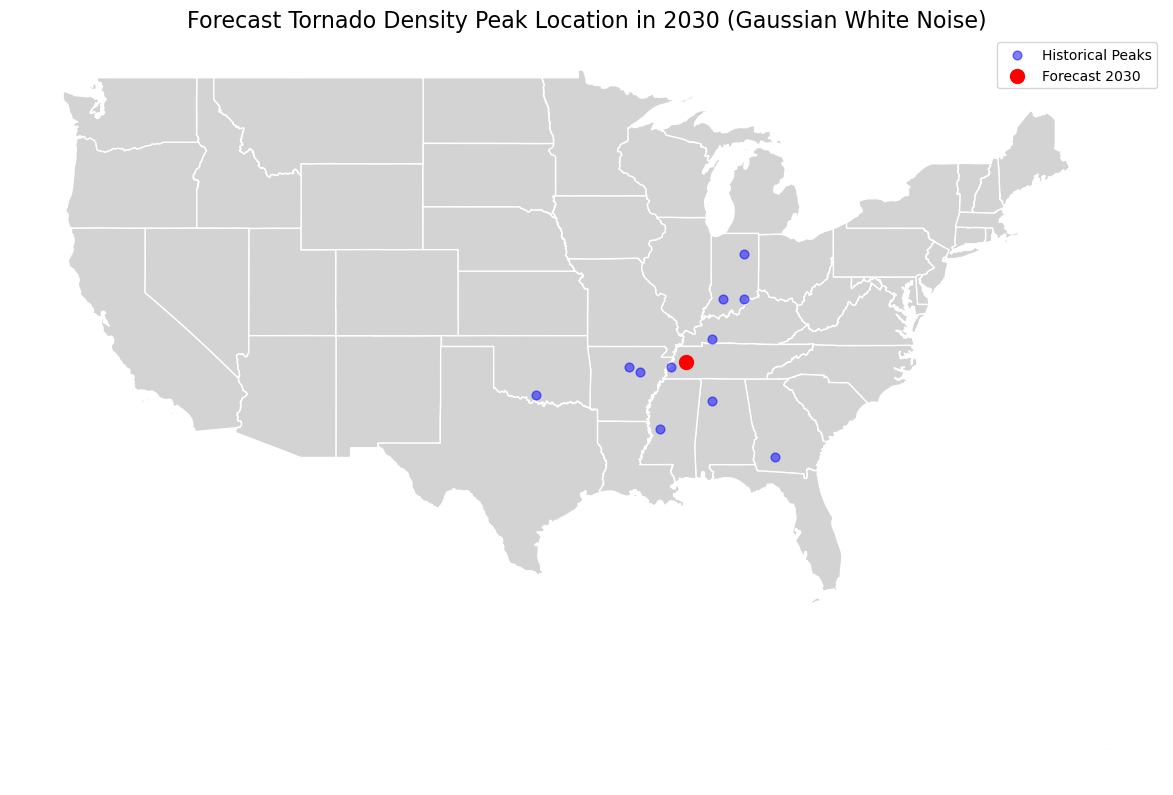

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Create forecast point
forecast_point = gpd.GeoDataFrame(
    {'geometry': [Point(lon_mu, lat_mu)], 'label': ['Forecast 2030']},
    crs="EPSG:4326"
)

# Load US counties or states shapefile
# (You may already have `contiguous_states`)
fig, ax = plt.subplots(figsize=(12, 8))
contiguous_states.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot historical peaks
gdf_peaks = gpd.GeoDataFrame(
    df_stats, geometry=gpd.points_from_xy(df_stats['peak_lon'], df_stats['peak_lat']),
    crs="EPSG:4326"
)
gdf_peaks.plot(ax=ax, color='blue', markersize=40, alpha=0.5, label='Historical Peaks')

# Plot forecast
forecast_point.plot(ax=ax, color='red', markersize=100, label='Forecast 2030')

ax.set_title("Forecast Tornado Density Peak Location in 2030 (Gaussian White Noise)", fontsize=16)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.tight_layout()

plt.rcParams['figure.figsize'] = [12,7]

plt.rcParams['font.family'] = 'sans-serif'

plt.rcParams['font.size'] = 16

plt.rcParams['xtick.direction'] = 'in'

plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['xtick.major.size'] = 14

plt.rcParams['xtick.minor.size'] = 9

plt.rcParams['ytick.major.size'] = 14

plt.rcParams['ytick.minor.size'] = 9


<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your data
df = pd.read_csv("data_tornado-density-peaks.csv")

# Extract mid-year from year_bin
df['mid_year'] = df['year_bin'].apply(lambda b: (int(b.split('-')[0]) + int(b.split('-')[1])) // 2)

# Drop rows with missing values
df = df.dropna(subset=['peak_lat', 'peak_lon'])


In [6]:
X = df[['mid_year']]
y_lat = df['peak_lat']
y_lon = df['peak_lon']

lat_model = LinearRegression().fit(X, y_lat)
lon_model = LinearRegression().fit(X, y_lon)

# Predict for 2030
forecast_year = 2030
lat_2030 = lat_model.predict([[forecast_year]])[0]
lon_2030 = lon_model.predict([[forecast_year]])[0]

print(f"Forecast 2030 Location (F3–F5 tornadoes): ({lat_2030:.2f}°N, {lon_2030:.2f}°W)")


Forecast 2030 Location (F3–F5 tornadoes): (35.68°N, -89.21°W)


/Users/pandey.176/mambaforge/envs/fermipy/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/pandey.176/mambaforge/envs/fermipy/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


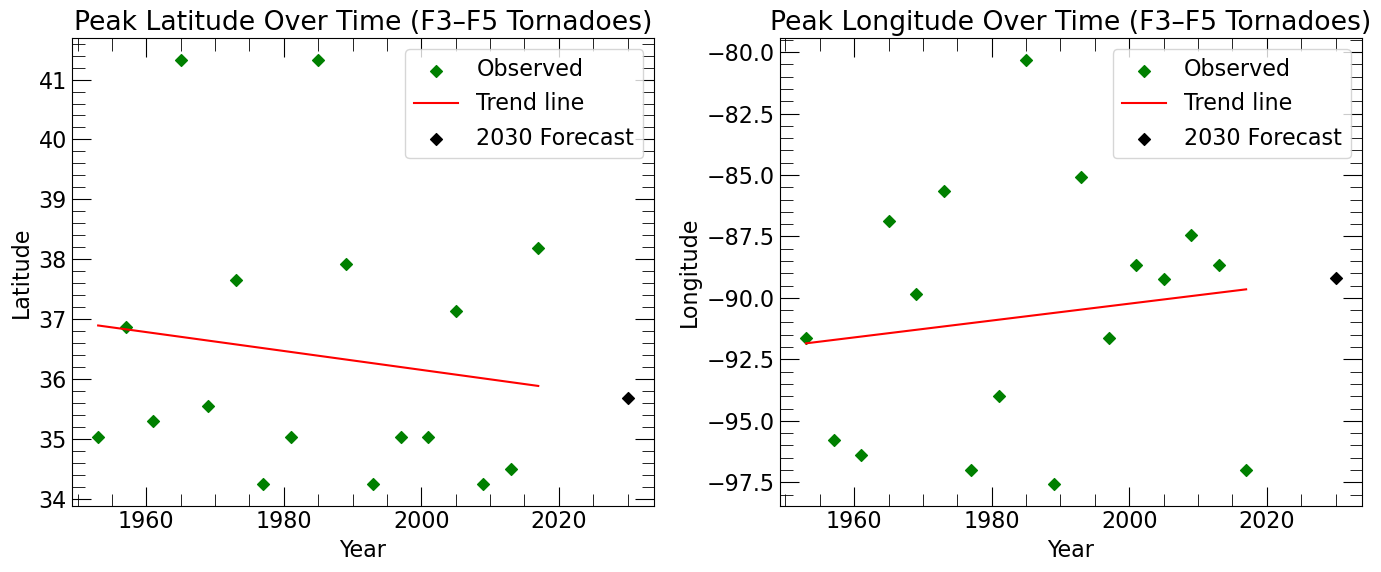

In [15]:
plt.figure(figsize=(14, 6))

# Latitude trend
plt.subplot(1, 2, 1)
plt.scatter(df['mid_year'], df['peak_lat'], label='Observed', marker= 'D',color='green')
plt.plot(df['mid_year'], lat_model.predict(X), color='red', label='Trend line')
#plt.axvline(forecast_year, linestyle='--', color='gray', alpha=0.6)
plt.scatter(forecast_year, lat_2030, color='black',  marker= 'D',label='2030 Forecast')
plt.title("Peak Latitude Over Time (F3–F5 Tornadoes)")
plt.xlabel("Year")
plt.ylabel("Latitude")
plt.legend()

# Longitude trend
plt.subplot(1, 2, 2)
plt.scatter(df['mid_year'], df['peak_lon'], label='Observed', marker= 'D',color='green')
plt.plot(df['mid_year'], lon_model.predict(X), color='red', label='Trend line')
#plt.axvline(forecast_year, linestyle='--', color='gray', alpha=0.6)
plt.scatter(forecast_year, lon_2030, color='black', marker= 'D', label='2030 Forecast')
plt.title("Peak Longitude Over Time (F3–F5 Tornadoes)")
plt.xlabel("Year")
plt.ylabel("Longitude")
plt.legend()

plt.tight_layout()
plt.show()
